# Weekly analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.decomposition import NMF
from tensorly.decomposition import non_negative_parafac

In [2]:
def cleaning(df, user_type=None, add_user_age=True):

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    df = df.dropna(subset=['birthyear'])

    if user_type is not None:
        assert user_type in ['Subscriber', 'Customer']
        df = df.query('usertype==@user_type')

    df = df.query('startstationlongitude!=0')
    df = df.query('startstationlatitude!=0')
    df = df.query('endstationlongitude!=0')
    df = df.query('endstationlatitude!=0')

    df.loc[:, 'starttime'] = pd.to_datetime(df.starttime)
    df.loc[:, 'stoptime'] = pd.to_datetime(df.stoptime)
    df.loc[:, 'year'] = df.starttime.dt.year
    df.loc[:, 'hour'] = df.starttime.dt.hour
    df.loc[:, 'weekday'] = df.starttime.dt.weekday.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')
    df.loc[:, 'weekday-hour'] = df.hour.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')

    if add_user_age:
        df.loc[:, 'user_age'] = df.year - df.birthyear
        df = df.query('user_age>=0')
        df = df.query('user_age<=80')

    return df


In [3]:
def load_data(date=None, date_from=None, date_to=None, clean=True):
    """
        date: (str) e.g., '201701'
    """

    if date is not None:
        zip_file = zipfile.ZipFile(
            f'../rawdata/{date}-citibike-tripdata.csv.zip')
        data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
        # data = pd.read_csv(f'../rawdata/{date}-citibike-tripdata.csv.zip', compression='zip')
        if clean:
            return cleaning(data)
        else:
            return data

    else:
        if date_from is not None and date_to is not None:
            return pd.concat([load_data(date=date.strftime("%Y%m"))
                              for date in pd.date_range(start=date_from, end=date_to, freq='M')])
        else:
            return None


In [20]:
def define_non_temporal_modes(df, facets, freq_rate=0.9, skip_mode=None):
    
    if skip_mode is None:
        skip_mode = [False] * len(facets)

    # Extracting the top [freq_rate] % attritbutes for each mode
    freq_rates = df[facets].nunique().values * freq_rate
    freq_shape = freq_rates.astype(int)
    freq_entities = [df.groupby(a).size().sort_values().iloc[-r:].index if not s else [] for a, r, s in zip(facets, freq_shape, skip_mode)]

    # Filtering out the infrequent attributes
    valid_events = df
    for i, (mode, skip) in enumerate(zip(facets, skip_mode)):
        if not skip:
            valid_events = valid_events[valid_events[mode].isin(freq_entities[i])]

    print('Filtered out {} samples'.format(df.shape[0] - valid_events.shape[0]))

    # Getting the attributes to keep track
    multi_index = valid_events.groupby(facets).size().rename('size').to_frame()
    multi_index = multi_index.unstack(fill_value=0).stack()

    shape = valid_events[facets].nunique().values.astype(int)

    return multi_index, shape

In [22]:
df = load_data('201702')
df.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,year,hour,weekday,weekday-hour,user_age
0,1087,2017-02-01 00:00:13,2017-02-01 00:18:20,345,W 13 St & 6 Ave,40.736494,-73.997044,305,E 58 St & 3 Ave,40.760958,-73.967245,17432,Subscriber,1966.0,1,2017,0,2-Wed,0-Wed,51.0
2,212,2017-02-01 00:00:34,2017-02-01 00:04:06,336,Sullivan St & Washington Sq,40.730477,-73.999061,439,E 4 St & 2 Ave,40.726281,-73.989780,16826,Subscriber,1984.0,1,2017,0,2-Wed,0-Wed,33.0
3,1140,2017-02-01 00:00:44,2017-02-01 00:19:44,484,W 44 St & 5 Ave,40.755003,-73.980144,3295,Central Park W & W 96 St,40.791270,-73.964839,27052,Subscriber,1980.0,1,2017,0,2-Wed,0-Wed,37.0
4,320,2017-02-01 00:00:42,2017-02-01 00:06:02,490,8 Ave & W 33 St,40.751551,-73.993934,3431,E 35 St & 3 Ave,40.746524,-73.977885,25238,Subscriber,1987.0,1,2017,0,2-Wed,0-Wed,30.0
5,277,2017-02-01 00:00:56,2017-02-01 00:05:34,285,Broadway & E 14 St,40.734546,-73.990741,251,Mott St & Prince St,40.723180,-73.994800,20617,Subscriber,1975.0,1,2017,0,2-Wed,0-Wed,42.0


## 3rd-order tensor: (time, station, user_age)

In [31]:
skip_mode = [False, False]
facets = ['startstationid', 'user_age']
multi_index, shape = define_non_temporal_modes(df, facets, skip_mode=skip_mode)

rank = 6
time_range = 168
sub_tensor = np.zeros((time_range, *shape))

for t, (d, g) in enumerate(df.set_index('starttime').groupby(pd.Grouper(freq='H'))):
    # t: time point
    # d: datetime information
    # g: trip data in an hour

    events = multi_index.join(g.groupby(facets).size().rename('data'), how='left')
    tensor = events.data.fillna(0.).values.reshape((-1, *shape))
    # print(tensor.shape)
    sub_tensor[t % time_range] = tensor

    if t % time_range == time_range - 1:
        # Perform tensnor decomposition
        weights, factors = non_negative_parafac(sub_tensor, rank)
        plt.plot(factors[0])
        plt.show()

    break

Filtered out 7999 samples


In [33]:
def plot_component():
    # TODO: meshgrid and gaussian filtering -> fill up the map
    return

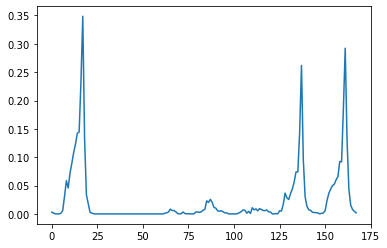

In [34]:
# Time mode
plt.plot(factors[0][:, 0])

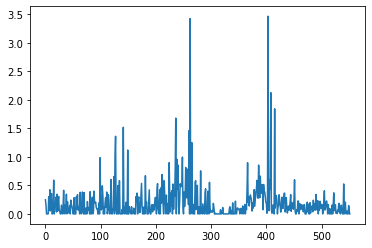

In [48]:
# Non-temporal mode (station)
plt.plot(factors[1][:, 4])

In [59]:
geo_specific_data = pd.DataFrame(
    factors[1][:, 0],
    columns=['component'],
    index=multi_index.reset_index()[facets[0]].unique())

geo_specific_data.join(df.set_index('startstationid'), how='left')

# geo_specific_data

,component,tripduration,starttime,stoptime,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,year,hour,weekday,weekday-hour,user_age
72,2.530070e-01,885,2017-02-01 07:11:19,2017-02-01 07:26:04,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,17560,Subscriber,1981.0,1,2017,7,2-Wed,7-Wed,36.0
72,2.530070e-01,401,2017-02-01 07:12:01,2017-02-01 07:18:43,W 52 St & 11 Ave,40.767272,-73.993929,488,W 39 St & 9 Ave,40.756458,-73.993722,26417,Subscriber,1974.0,1,2017,7,2-Wed,7-Wed,43.0
72,2.530070e-01,284,2017-02-01 07:34:25,2017-02-01 07:39:09,W 52 St & 11 Ave,40.767272,-73.993929,500,Broadway & W 51 St,40.762288,-73.983362,15620,Subscriber,1982.0,1,2017,7,2-Wed,7-Wed,35.0
72,2.530070e-01,137,2017-02-01 07:44:22,2017-02-01 07:46:39,W 52 St & 11 Ave,40.767272,-73.993929,508,W 46 St & 11 Ave,40.763414,-73.996674,26496,Subscriber,1963.0,1,2017,7,2-Wed,7-Wed,54.0
72,2.530070e-01,1041,2017-02-01 07:47:58,2017-02-01 08:05:19,W 52 St & 11 Ave,40.767272,-73.993929,474,5 Ave & E 29 St,40.745168,-73.986831,26948,Subscriber,1975.0,1,2017,7,2-Wed,7-Wed,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,2.007010e-41,494,2017-02-28 08:44:54,2017-02-28 08:53:09,Penn Station Valet - Valet Scan,40.751284,-73.996925,517,Pershing Square South,40.751581,-73.977910,17071,Subscriber,1956.0,1,2017,8,1-Tue,8-Tue,61.0
3450,2.007010e-41,381,2017-02-28 08:45:43,2017-02-28 08:52:05,Penn Station Valet - Valet Scan,40.751284,-73.996925,524,W 43 St & 6 Ave,40.755273,-73.983169,27835,Subscriber,1986.0,1,2017,8,1-Tue,8-Tue,31.0
3450,2.007010e-41,481,2017-02-28 08:47:02,2017-02-28 08:55:03,Penn Station Valet - Valet Scan,40.751284,-73.996925,434,9 Ave & W 18 St,40.743174,-74.003664,27602,Subscriber,1976.0,1,2017,8,1-Tue,8-Tue,41.0
3450,2.007010e-41,2318,2017-02-28 08:47:40,2017-02-28 09:26:18,Penn Station Valet - Valet Scan,40.751284,-73.996925,315,South St & Gouverneur Ln,40.703554,-74.006702,16717,Subscriber,1961.0,1,2017,8,1-Tue,8-Tue,56.0


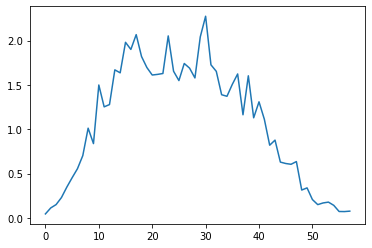

In [38]:
# Non-temporal mode (user_age)
plt.plot(factors[2][:, 0])